In [64]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy
from astropy.coordinates import SkyCoord
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
import astropy.units as u

In [97]:
with open('../processed_data/Baseline_v_3_0/Baselinev30_unlensed_newrates_batch001.pkl', 'rb') as f:
    sne = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_unlensed_batch001.pkl', 'rb') as f:
    sne_old = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_microlensing2_numimages=2_batch001.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_fixedquadproblem_numimages=4_batch001.pkl', 'rb') as f:
    quads = pickle.load(f)

In [105]:
doubles.iloc[2647]

time_series                                                                 NaN
z_source                                                               0.490309
z_lens                                                                 0.171462
H0                                                                         67.8
theta_E                                                                1.281157
obs_peak                      [[22.135416964860504, 22.64236180323156], [21....
obs_times                     [-29.804299770054058, -29.79668402938114, -29....
obs_bands                     [g, i, r, y, z, g, i, r, y, i, r, g, i, r, y, ...
model_mag                     [[29.969153915660772, inf], [28.53000079084228...
obs_mag                       [[inf, inf], [inf, inf], [inf, inf], [inf, inf...
obs_mag_error                 [[nan, nan], [nan, nan], [nan, nan], [nan, nan...
obs_snr                       [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...
obs_mag_unresolved            [nan, nan,

In [98]:
zd = doubles['z_source']
zq = quads['z_source']
zn = sne['z_source']

print("Fraction with redshift <= 0.8")
print(len(zd[zd <= 0.8])/len(zd))
print(len(zq[zq <= 0.8])/len(zq))
print(len(zn[zn <= 0.8])/len(zn))

Fraction with redshift <= 0.8
0.4314
0.4034
0.6756


## Redshift distributions

In [58]:
def pdf_red(zmax):
    z = np.linspace(0, zmax, 100)
    rate = 2.35 * 10**4  # from Perley 2020
    volume = Planck18.comoving_volume(z).to("Gpc**3").value
    z_rate = volume * rate
    rates = np.diff(z_rate)
    pdf = rates/np.nansum(rates)
    x = (z[:-1]+z[1:])*.5
    return x, pdf

z, rate = pdf_red(zmax=1.2)

print(len(sne))

5000


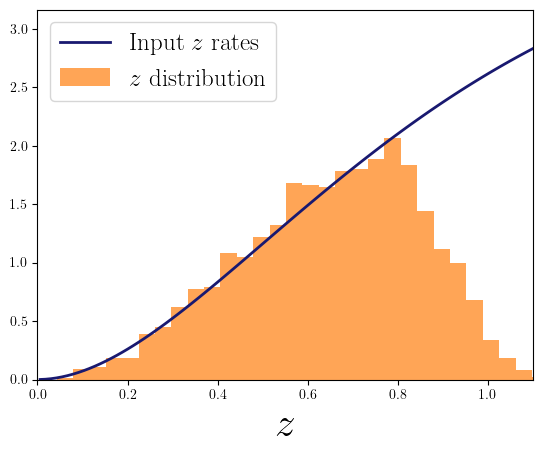

In [9]:
plt.hist(sne['z_source'], bins=30, color='C1', alpha=0.7, density=True, label=r'$z$ distribution')
plt.plot(z, rate * 145, color='midnightblue', lw=2, label=r'Input $z$ rates')
plt.legend(fontsize=18)
plt.xlim(0, 1.1)
plt.xlabel(r"Supernova redshift", fontsize=22)
plt.show()

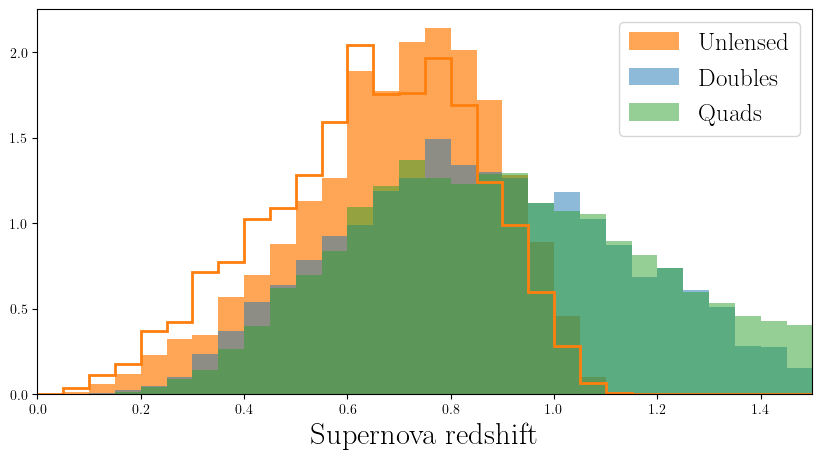

In [87]:
plt.figure(figsize=(10, 5))
zrange = (0, 1.5)
plt.hist(sne['z_source'], bins=30, color='C1', alpha=0.7, density=True, label=r'Unlensed', range=zrange)
plt.hist(sne_old['z_source'], bins=30, color='C1', histtype='step', density=True, range=zrange, lw=2)
plt.hist(doubles['z_source'], bins=30, color='C0', alpha=0.5, density=True, label=r'Doubles', range=zrange)
plt.hist(quads['z_source'], bins=30, color='C2', alpha=0.5, density=True, label=r'Quads', range=zrange)
plt.legend(fontsize=18)
plt.xlim(0, 1.5)
plt.xlabel(r"Supernova redshift", fontsize=22)
#plt.savefig("../Results/Figures/z_distributions_lensed_unlensed_newold.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

## Yearly rates and number of observations

In [99]:
mlim = 25
dt_doubles, dt_quads = [], []
Nobs_doubles, Nobs_quads = [], []
duration_doubles, duration_quads = [], []
mutot_doubles, mutot_quads = [], []
m_peak_doubles, m_peak_quads = [], []

for s in range(len(doubles)):
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    
    try:
        Nobs_doubles.append(len(doubles['obs_mag_unresolved'][s][doubles['obs_mag_unresolved'][s] < mlim]))
        Nobs_quads.append(len(quads['obs_mag_unresolved'][s][quads['obs_mag_unresolved'][s] < mlim]))
    except:
        Nobs_doubles.append(np.nan)
        Nobs_quads.append(np.nan)
        
    duration_doubles.append(doubles['obs_end'][s] - doubles['obs_start'][s])
    duration_quads.append(quads['obs_end'][s] - quads['obs_start'][s])
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    m_peak_doubles.append(np.nanmin(doubles['obs_mag_unresolved'][s]))
    m_peak_quads.append(np.nanmin(quads['obs_mag_unresolved'][s]))
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
Nobs_doubles = np.array(Nobs_doubles)
Nobs_quads = np.array(Nobs_quads)
duration_doubles = np.array(duration_doubles)
duration_quads = np.array(duration_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
m_peak_doubles = np.array(m_peak_doubles)
m_peak_quads = np.array(m_peak_quads)

In [101]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)

# Minimum number of observations
md_Nobs8 = Nobs_doubles > 8
md_Nobs30 = Nobs_doubles > 50
mq_Nobs8 = Nobs_quads > 8
mq_Nobs30 = Nobs_quads > 50
md_Nobs_lower15 = Nobs_doubles < 15
mq_Nobs_lower15 = Nobs_quads < 15

# Minimum time delay
dt_lim = 10
md_dt_lim = dt_doubles > dt_lim
mq_dt_lim = dt_quads > dt_lim

# Duration
md_duration = duration_doubles > 50
mq_duration = duration_quads > 50

In [102]:
# Yearly predicted rates by Wojtak et al.

rates_total = 89 * 3
fraction_quads = 0.28
fraction_doubles = 0.72
rates_quads = rates_total * fraction_quads
rates_doubles = rates_total * fraction_doubles

sd = rates_doubles / len(doubles) / 1.5
sq = rates_quads / len(quads) / 1.5

(array([ 16., 152., 257., 337., 390., 412., 389., 358., 363., 351., 278.,
        288., 221., 201., 182., 143., 121.,  91.,  72.,  80.,  42.,  42.,
         36.,  41.,  23.,  20.,  21.,  12.,   8.,   3.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
        1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ,
        1.66666667, 1.73333333, 1.8       , 1.86666667, 1.93333333,
        2.        ]),
 <BarContainer object of 30 artists>)

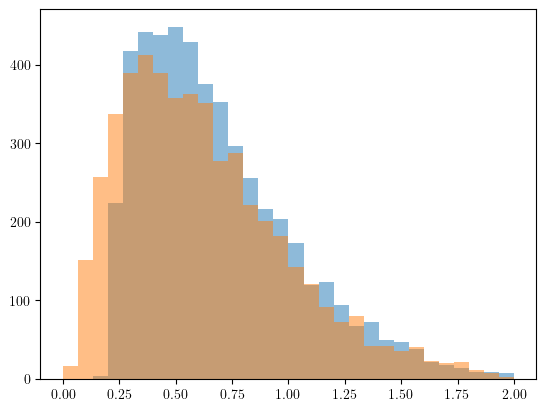

In [91]:
plt.hist((doubles['theta_E']), range=(0,2), bins=30, alpha=0.5)
plt.hist((quads['theta_E']), range=(0,2), bins=30, alpha=0.5)

(array([1121.,  842.,  681.,  473.,  366.,  270.,  211.,  163.,  150.,
         113.,   93.,   81.,   73.,   53.,   36.,   30.,   31.,   30.,
          17.,   28.,   19.,   15.,   12.,   12.,   11.,   13.,   11.,
           5.,    7.,    7.]),
 array([  0.        ,   3.33333333,   6.66666667,  10.        ,
         13.33333333,  16.66666667,  20.        ,  23.33333333,
         26.66666667,  30.        ,  33.33333333,  36.66666667,
         40.        ,  43.33333333,  46.66666667,  50.        ,
         53.33333333,  56.66666667,  60.        ,  63.33333333,
         66.66666667,  70.        ,  73.33333333,  76.66666667,
         80.        ,  83.33333333,  86.66666667,  90.        ,
         93.33333333,  96.66666667, 100.        ]),
 <BarContainer object of 30 artists>)

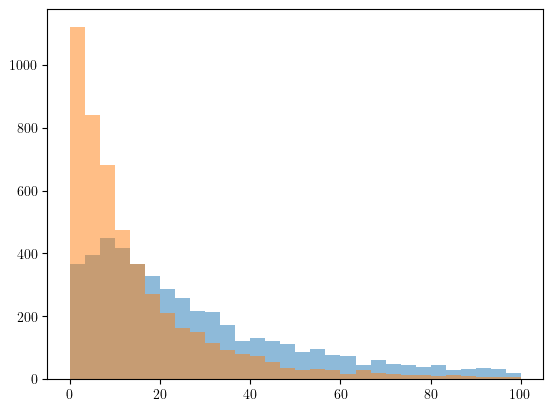

In [92]:
plt.hist((dt_doubles), range=(0,100), bins=30, alpha=0.5)
plt.hist((dt_quads), range=(0,100), bins=30, alpha=0.5)

(array([ 14.,  19.,  25.,  32.,  44.,  52.,  67.,  91., 106., 142., 123.,
        152., 151., 202., 164., 141., 123., 104.,  88.,  51.,  38.,  18.,
         15.,   7.,   6.,   2.,   0.,   0.,   0.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 30 artists>)

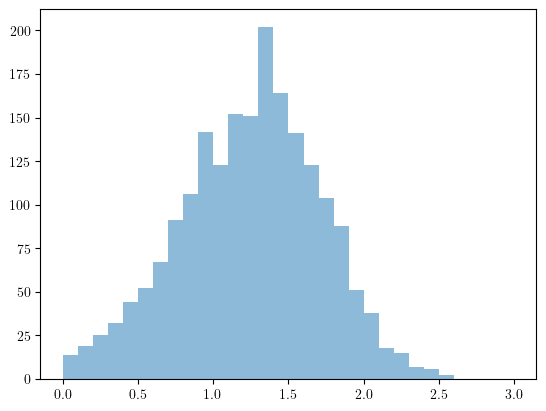

In [16]:
plt.hist(list(np.log10(dt_doubles)) + list(np.log10(dt_quads)), range=(0,3), bins=30, alpha=0.5)
#plt.hist(np.log10(dt_quads), range=(0,3), bins=30, alpha=0.5)

In [17]:
print(np.median(dt_quads))
print(np.median(dt_doubles))
print(np.median(list(dt_quads) + list(dt_doubles)))
print(10**1.39)
print(" ")
print((33.48536+29.38424)/2)

13.940934186513221
24.506173959295893
18.814401200201743
24.547089156850298
 
31.4348


In [93]:
print("WFD")
print(" ")

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_WFD) & (md_detected) & (md_rol)).sum()*sd)
print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq + ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq + ((md_WFD) & (md_detected) & (md_rol)).sum()*sd)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq + ((md_WFD) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq + ((md_WFD) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected)).sum()*sd + ((mq_WFD) & (mq_detected)).sum()*sq)/2)

WFD
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected  :      13.610591999999999      12.918527999999998
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected  :      6.848016000000001      6.499136000000001
 
--- Total ---
             Non-rolling    ---    Rolling
N detected  :      20.458607999999998      19.417664
N with time delay > 10 days :  12.55256      12.125359999999999
Total N of lensed SNe:  19.938136


In [22]:
print("galactic plane")
print(" ")

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((md_gal) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_gal) & (md_detected) & (md_rol)).sum()*sd)
print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_gal) & (mq_detected) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_gal) & (mq_detected) & (mq_rol)).sum()*sq)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_gal) & (mq_detected) & (mq_nonrol)).sum()*sq + ((md_gal) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((mq_gal) & (mq_detected) & (mq_rol)).sum()*sq + ((md_gal) & (md_detected) & (md_rol)).sum()*sd)
print("N with time delay > 10 days : ", ((mq_gal) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq + ((md_gal) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd,"    ", 
                            ((mq_gal) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq + ((md_gal) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd)
print("Total N of lensed SNe: ", (((md_gal) & (md_detected)).sum()*sd + ((mq_gal) & (mq_detected)).sum()*sq)/2)

galactic plane
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected  :      5.25456      4.10112
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected  :      3.2396000000000003      3.33928
 
--- Total ---
             Non-rolling    ---    Rolling
N detected  :      8.49416      7.4404
N with time delay > 10 days :  5.66752      4.43576
Total N of lensed SNe:  7.967280000000001


In [23]:
print("DDF")
print(" ")

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((md_DDF) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((md_DDF) & (md_detected) & (md_rol)).sum()*sd)
print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_DDF) & (mq_detected) & (mq_nonrol)).sum()*sq,"    ", 
                            ((mq_DDF) & (mq_detected) & (mq_rol)).sum()*sq)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("N detected  :     ",  ((mq_DDF) & (mq_detected) & (mq_nonrol)).sum()*sq + ((md_DDF) & (md_detected) & (md_nonrol)).sum()*sd,"    ", 
                            ((mq_DDF) & (mq_detected) & (mq_rol)).sum()*sq + ((md_DDF) & (md_detected) & (md_rol)).sum()*sd)
print("N with time delay > 10 days : ", ((mq_DDF) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq + ((md_DDF) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd,"    ", 
                            ((mq_DDF) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq + ((md_DDF) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd)
print("Total N of lensed SNe: ", (((md_DDF) & (md_detected)).sum()*sd + ((mq_DDF) & (mq_detected)).sum()*sq)/2)

DDF
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected  :      0.25632      0.12816
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected  :      0.04984      0.04984
 
--- Total ---
             Non-rolling    ---    Rolling
N detected  :      0.30616      0.178
N with time delay > 10 days :  0.30616      0.0
Total N of lensed SNe:  0.24208


## DDF lensed SNe

In [50]:
print(len(doubles[(md_DDF) & (md_detected)]))
print(len(quads[(mq_DDF) & (mq_detected)]))

3
2


195


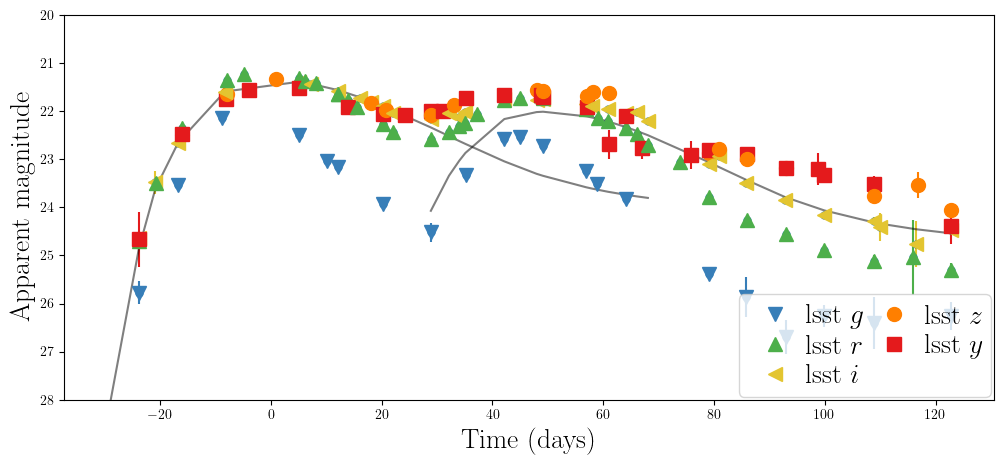

In [103]:
for index in np.where(md_DDF)[0]:
    
    print(index)
    
    index = 2647
    
    #print("Time delay: ", doubles['time_delay'][index][1])
    #print("Detected? ", md_detected[index])
    #print(" ")
    
    plt.figure(figsize=(12, 5))

    colours = {'lsstg': '#377eb8', 'lsstr': '#4daf4a',
                       'lssti': '#e3c530', 'lsstz': '#ff7f00', 'lssty': '#e41a1c'}

    markers = {'lsstg': 'v', 'lsstr': '^',
               'lssti': '<', 'lsstz': 'o', 'lssty': 's'}

    legend_handles = [Line2D([0], [0], marker=markers['lsstg'], color=colours['lsstg'], label=r'lsst $g$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lsstr'], color=colours['lsstr'], label=r'lsst $r$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lssti'], color=colours['lssti'], label=r'lsst $i$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lsstz'], color=colours['lsstz'], label=r'lsst $z$', ms=10, lw=0),
                          Line2D([0], [0], marker=markers['lssty'], color=colours['lssty'], label=r'lsst $y$', ms=10, lw=0)]

    legend1 = plt.legend(handles=legend_handles, loc='lower right', ncol=2, handletextpad=.1, borderaxespad=.1,
                         labelspacing=.1, borderpad=.3, columnspacing=.1, fontsize=20)

    df = doubles
    day = df['obs_times'][index]
    mags = df['obs_mag_unresolved'][index]
    error = df['mag_unresolved_error'][index]
    filters = df['obs_bands'][index]
    mag_im1 = df['model_mag'][index][:,0][filters == 'i']
    mag_im2 = df['model_mag'][index][:,1][filters == 'i']

    plt.plot(day, mags, '.' , ms=10)
    plt.plot(day[filters == 'i'], mag_im1, color='black', alpha=0.5)
    plt.plot(day[filters == 'i'], mag_im2, color='black', alpha=0.5)

    for obs in range(len(day)):
        band = 'lsst' + filters[obs]
        plt.plot(day[obs], mags[obs], color=colours[band], marker=markers[band], ms=10, label=band)
        plt.vlines(day[obs], mags[obs] - error[obs], mags[obs] + error[obs], color=colours[band])

    plt.xlabel("Time (days)", fontsize=20)
    plt.ylabel("Apparent magnitude", fontsize=20)
    plt.ylim(28, 20)
    
    break

## Lensed SN sky location

In [65]:
d_ra, d_dec = [], []
q_ra, q_dec = [], []

for c in range(len(doubles)):
    d_ra.append(doubles['coords'][c][0])
    d_dec.append(doubles['coords'][c][1])
    q_ra.append(quads['coords'][c][0])
    q_dec.append(quads['coords'][c][1])

d_ra = coord.Angle(np.array(d_ra), u.degree)
d_dec = coord.Angle(np.array(d_dec), u.degree)
q_ra = coord.Angle(np.array(q_ra), u.degree)
q_dec = coord.Angle(np.array(q_dec), u.degree)
d_ra = - d_ra.wrap_at(180*u.degree)
q_ra = - q_ra.wrap_at(180*u.degree)

396
560
 
73
132


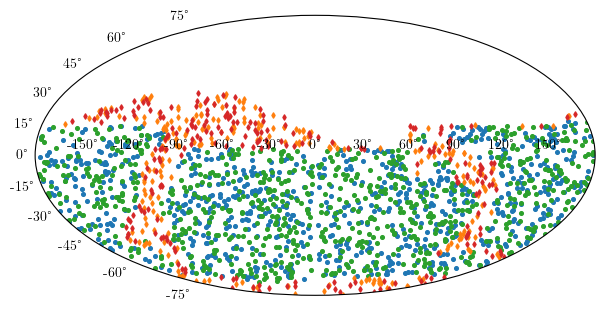

In [77]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(d_ra.radian[(md_WFD)], d_dec.radian[(md_WFD)], s=7, c='C0')
im1 = ax1.scatter(q_ra.radian[(mq_WFD)], q_dec.radian[(mq_WFD)], s=7, c='C2')

im1 = ax1.scatter(d_ra.radian[(md_gal)], d_dec.radian[(md_gal)], s=7, c='C1', marker='d')
im1 = ax1.scatter(q_ra.radian[(mq_gal)], q_dec.radian[(mq_gal)], s=7, c='C3', marker='d')


print(len(d_ra.radian[(md_WFD) & (md_detected)]))
print(len(q_ra.radian[(mq_WFD) & (mq_detected)]))
print(" ")
print(len(d_ra.radian[(md_gal) & (md_detected)]))
print(len(q_ra.radian[(mq_gal) & (mq_detected)]))

# plt.savefig("../Results/Figures/SkyDistrAll.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
seaborn.kdeplot(list(Nobs_doubles[(md_detected) & (md_nonrol)]) + list(Nobs_quads[(mq_detected) & (mq_nonrol)]), 
                ax=ax, fill=True, alpha=0.5, label="Non-rolling", bw_adjust=0.5)
seaborn.kdeplot(list(Nobs_doubles[(md_detected) & (md_rol)]) + list(Nobs_quads[(mq_detected) & (mq_rol)]), 
                ax=ax, fill=True, alpha=0.5, label="Rolling", bw_adjust=0.5)
# plt.hist(Nobs_doubles[(md_detected) & (md_nonrol)], bins=40, alpha=0.5, density=True)
# plt.hist(Nobs_doubles[(md_detected) & (md_rol)], bins=40, alpha=0.5, density=True)
ax.set_xlabel(r"$N_{\rm{obs}}$", fontsize=25)
ax.set_ylabel(r"Density", fontsize=25, labelpad=15)
plt.legend(fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

#plt.savefig("../Results/Figures/Cadence_Nobs_rolling_nonrolling_v30.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

In [32]:
def N_glsne(Nobs_lim, cadence, configuration, rolling):
    # Calculate the yearly number of detected lensed SNe with N_obs number of observations.
    
    mlim = 25
    Nobs_doubles, Nobs_quads = [], []

    for s in range(len(doubles)):
        Nobs_doubles.append(len(doubles['obs_mag_unresolved'][s][doubles['obs_mag_unresolved'][s] < mlim]))
        try:
            Nobs_quads.append(len(quads['obs_mag_unresolved'][s][quads['obs_mag_unresolved'][s] < mlim]))
        except:
            Nobs_quads.append(np.nan)

    Nobs_doubles = np.array(Nobs_doubles)
    Nobs_quads = np.array(Nobs_quads)
    
    if cadence == 'nonrol' and configuration == 'doubles':
        number = ((md_detected) & (md_nonrol) & (Nobs_doubles > Nobs_lim)).sum()*sd
    elif cadence == 'rol' and configuration == 'doubles':
        number = ((md_detected) & (md_rol) & (Nobs_doubles > Nobs_lim)).sum()*sd
    elif cadence == 'nonrol' and configuration == 'quads':
        number = ((mq_detected) & (mq_nonrol) & (Nobs_quads > Nobs_lim)).sum()*sq
    elif cadence == 'rol' and configuration == 'quads':
        number = ((mq_detected) & (mq_rol) & (Nobs_quads > Nobs_lim)).sum()*sq
    elif cadence == 'nonrol' and configuration == 'all':
        number = ((mq_detected) & (mq_nonrol) & (Nobs_quads > Nobs_lim)).sum()*sq + ((md_detected) & (md_nonrol) & (Nobs_doubles > Nobs_lim)).sum()*sd
    elif cadence == 'rol' and configuration == 'all':
        number = ((mq_detected) & (mq_rol) & (Nobs_quads > Nobs_lim)).sum()*sq + ((md_detected) & (md_rol) & (Nobs_doubles > Nobs_lim)).sum()*sd
    
    elif cadence == 'rol' and configuration == 'all' and rolling == 'active':
        number = ((mq_detected) & (mq_rol) & (active_quads) & (Nobs_quads > Nobs_lim)).sum()*sq + 
        ((md_detected) & (md_rol) & (active_doubles) & (Nobs_doubles > Nobs_lim)).sum()*sd 
    
    return number    
    

In [33]:
Nobs_range = np.linspace(1, 100, 100)
N_rol_all = []
N_nonrol_all = []

for n in Nobs_range:
    N_rol_all.append(N_glsne(n, 'rol', 'all'))
    N_nonrol_all.append(N_glsne(n, 'nonrol', 'all', None))
    
N_nonrol_all = np.array(N_nonrol_all)
N_rol_all = np.array(N_rol_all)

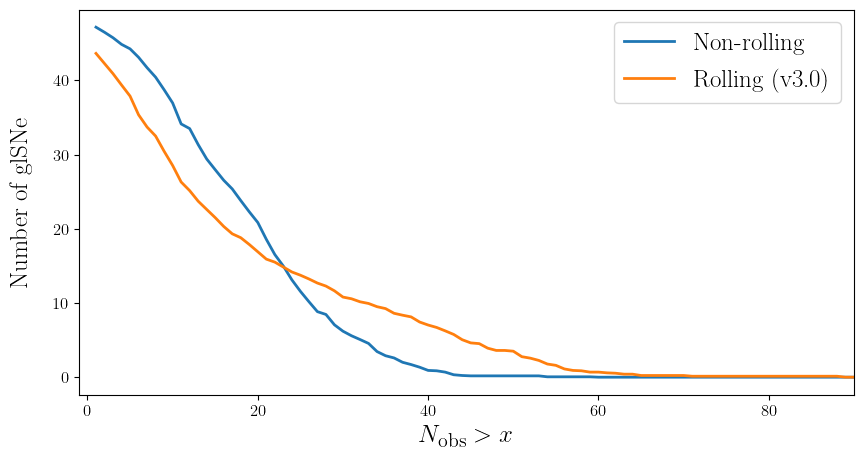

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(Nobs_range, N_nonrol_all, label="Non-rolling", lw=2)
plt.plot(Nobs_range, N_rol_all, label="Rolling (v3.0)", lw=2)

plt.xlabel(r"$N_{\Large \textrm{obs}} > x$", fontsize=18)
plt.ylabel(r"Number of glSNe", fontsize=18, labelpad=15)
plt.xlim(-1, 90)
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
#plt.savefig("../Results/Figures/Cadence_Nglsne_Nobs_all_v30.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

In [55]:
def is_active(coords):
    ra, dec = coords
    return (((dec > -16) & 
            ((ra < 95) | (ra > 260))) | (((dec > -49) & (dec <= -31)) & ((ra <= 120) | (ra > 245))) |
             (((dec > -25) & (dec <= -8)) & (ra >= 110) & (ra <= 245)) | (dec > 3)  | (dec < -72) )

In [57]:
active_

print(doubles['coords'][0])
print(is_active(doubles['coords']))

[354.37869963  -7.23655398]


ValueError: too many values to unpack (expected 2)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(Nobs_range, N_nonrol_all, label="Non-rolling", lw=2)
plt.plot(Nobs_range, N_rol_all, label="Rolling (v3.0)", lw=2)

plt.xlabel(r"$N_{\Large \textrm{obs}} > x$", fontsize=18)
plt.ylabel(r"Number of glSNe", fontsize=18, labelpad=15)
plt.xlim(-1, 90)
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
#plt.savefig("../Results/Figures/Cadence_Nglsne_Nobs_all_v30.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

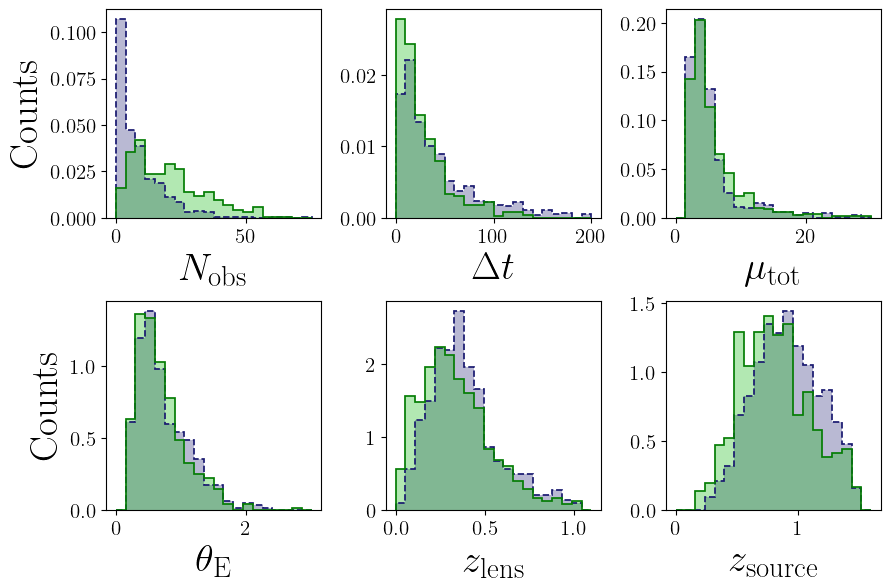

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6.5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
ax = ax.flatten()
bins = 20
fs = 28
tfs = 15

def histogram(data, ax, detected, start=None, stop=None):
    
    kwargs1 = {'density': True, 'bins': bins, 'histtype': 'stepfilled', 'alpha': 0.3}
    kwargs2 = {'density': True, 'bins': bins, 'histtype': 'step', 'lw': 1.25}
    
    if detected:
        color1 = '#00b300'
        color2 = '#057d05'
        ls = '-'
    else:
        color = '#9731e0'
        color1 = 'midnightblue'
        color2 = 'midnightblue'
        ls = '--'
              
    if start == None:
        start = min(data)
    if stop == None:
        stop = max(data)
              
    ax.hist(data, color=color1, range=(start, stop), **kwargs1)
    ax.hist(data, color=color2, range=(start, stop), ls=ls, **kwargs2)


for a in ax:
    a.tick_params(axis='both', which='major', labelsize=tfs)
    a.tick_params(axis='both', which='minor', labelsize=tfs)
    
histogram(Nobs_doubles[md_nondetect], ax[0], detected=False, start=0, stop=75)
histogram(Nobs_doubles[md_detected], ax[0], detected=True, start=0, stop=75)
ax[0].set_ylabel("Counts", fontsize=fs)
ax[0].set_xlabel(r"$N_{\huge \textrm{obs}}$", fontsize=fs)

histogram(dt_doubles[md_nondetect], ax[1], detected=False, start=0, stop=200)
histogram(dt_doubles[md_detected], ax[1], detected=True, start=0, stop=200)
ax[1].set_xlabel(r"$\Delta{t}$", fontsize=fs)

histogram(mutot_doubles[md_nondetect], ax[2], detected=False, start=0, stop=30)
histogram(mutot_doubles[md_detected], ax[2], detected=True, start=0, stop=30)
ax[2].set_xlabel(r"$\mu_{\huge \textrm{tot}}$", fontsize=fs)

histogram(doubles['theta_E'][md_nondetect], ax[3], detected=False, start=0, stop=3)
histogram(doubles['theta_E'][md_detected], ax[3], detected=True, start=0, stop=3)
ax[3].set_xlabel(r"$\theta_{\huge \textrm{E}}$", fontsize=fs)
ax[3].set_ylabel("Counts", fontsize=fs)

histogram(doubles['z_lens'][md_nondetect], ax[4], detected=False, start=0, stop=1.1)
histogram(doubles['z_lens'][md_detected], ax[4], detected=True, start=0, stop=1.1)
ax[4].set_xlabel(r"$z_{\huge \textrm{lens}}$", fontsize=fs)

histogram(doubles['z_source'][md_nondetect], ax[5], detected=False, start=0, stop=1.6)
histogram(doubles['z_source'][md_detected], ax[5], detected=True, start=0, stop=1.6)
ax[5].set_xlabel(r"$z_{\huge \textrm{source}}$", fontsize=fs)

# plt.savefig("../Results/Figures/Cadence_accepted_rejected_doubles.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()